# Short-term Plasticity
## Generate Pre-synaptic Spike trains 
To investigate the synaptic plasticity, we need to first simulate the generation process of pre-synaptic spike trains. Here, we simulate two types of spike train given a constant firing rate $fr$, namely the regular spike trains and Poisson spike trains.

In [51]:
# Build up the environment
import matplotlib.pyplot as plt
import brainpy as bp
import brainpy.math as bm
import numpy as np

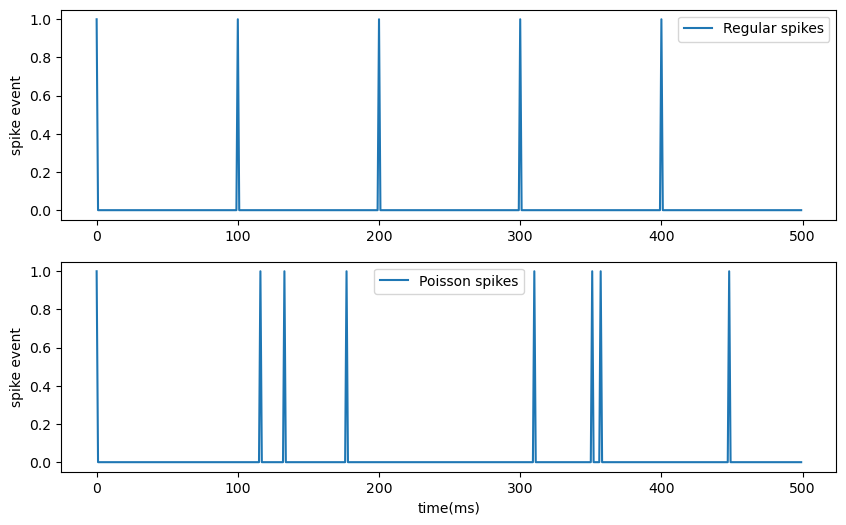

Total spike number: 5.0, Avearge spike frequency: 10.0 


In [53]:
def Pre_spike_generator(type='Poisson', fr=3., dt=1., T=1000.):
    assert type in ['Poisson', 'Regular']
    if type == 'Poisson':
        t = 0
        spike_train = np.zeros([int(T / dt), ])
        while t < T:
            prob = fr * 1e-3 * dt # the probability for the pre-synaptic neuron to fire a spike within this time window
            spike = (prob > np.random.rand(1)) #0 represents no spike is fired, 1 otherwise
            spike_train[int(t / dt)] = spike 
            t += dt
    if type == 'Regular':
        period = int(1 / fr * 1e3 / dt) # Calculate the average time period for a spike to be fired
        spike_train = np.zeros([int(T / dt), ]) 
        spike_train[::period] = 1 # In each time period, there is and only is one spike fired
    return spike_train
    
#Generate a spike train
dt = 1  # ms time window length 
T = 500  # ms
fr = 10.  # 1e-3*hz
spike_train_regular = Pre_spike_generator(type='Regular', fr=fr, dt=dt, T=T)
spike_train_Poisson = Pre_spike_generator(type='Poisson', fr=fr, dt=dt, T=T)
# Visualize the spike train
fig, ax = plt.subplots(2,1,figsize=(10, 6))
ax[0].plot(spike_train_regular,label='Regular spikes')
ax[0].legend()
ax[0].set_ylabel('spike event')
ax[1].plot(spike_train_Poisson,label='Poisson spikes')
ax[1].legend()
ax[1].set_xlabel('time(ms)')
ax[1].set_ylabel('spike event')
plt.show()


# Analyze the spike train
spike_time = np.where(spike_train_regular == 1)[0]
spike_num = np.sum(spike_train_regular)
spike_frequency = spike_num / T * 1e3
index = np.zeros(len(spike_time))
print("Total spike number: {}, Avearge spike frequency: {} ".format(spike_num, spike_frequency))



## Simulate the Post-synaptic current and Post-synaptic potential with a invariant exponential synapse model 
The post-synaptic current $I_{syn}$ is determined by the product of the post-synaptic conductance and the membrane potential,
$$ I_{syn}(t) = g(t)(V_{post}(t)-E_{syn}) $$
where $E_{syn}$ represents the reversal potential of the synapse, $V_{post}$ represents the membrane potential of the post synaptic neuron. However, considering the time window of the pre-synaptic spike is really small, during which the variations of the membrane potential $V_{post}$ is too small, so we can neglect the variations of the $V_{post}$ and substitute it with the resting membrane potential $V_{post\_rest}$. In such way, we can simplify the expression of $I_{syn}(t)$

$$I_{syn}(t) = g(t)(V_{post\_rest}-E_{syn}) $$
from which we see that $I_{syn}(t)$ is only determined by $g(t)$. The dynamics of $g(t)$ is simply modelled as an exponential decay:
$$ \frac{dg(t)}{dt} = -\frac{g(t)}{\tau_s} + Ay\delta(t-t_{sp})$$
where $A$ represents the synaptic strength (which might reflect the number of contacts between pre-synaptic axons and post-synaptic dendrites), $y$ represents the fraction of active neuro-transmitter. 

Before studying the short-term plasticity, we first simulate the EPSPs and EPSCs generate by a pre-synaptic Regular spike trains when the synaptic strength is invariant (invariable synaptic transimission):

  0%|          | 0/5000 [00:00<?, ?it/s]

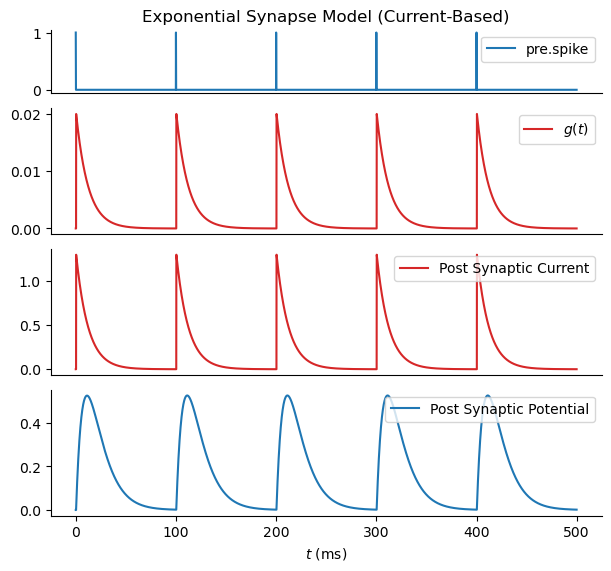

In [54]:

class Exponential(bp.synapses.TwoEndConn):
    def __init__(self, pre, post, conn, g_max=0.02, tau=12., delay_step=2, E=0., syn_type='CUBA',
                 method='exp_auto', **kwargs):
        super(Exponential, self).__init__(pre=pre, post=post, conn=conn)
        # 初始化参数
        self.tau = tau
        self.g_max = g_max
        self.delay_step = delay_step
        self.E = E

        assert syn_type in ['CUBA', 'COBA']  # current-based or conductance-based
        self.type = syn_type

        # 获取关于连接的信息
        self.pre2post = self.conn.require('pre2post')  # 获取从pre到post的连接信息

        # 初始化变量
        self.g = bm.Variable(bm.zeros(self.post.num))
        self.delay = bm.LengthDelay(self.pre.spike, delay_step)

        # 定义积分函数
        self.integral = bp.odeint(self.derivative, method=method)

    def derivative(self, g, t):
        dgdt = -g / self.tau
        return dgdt

    def update(self):
        # 取出延迟了delay_step时间步长的突触前脉冲信号
        delayed_pre_spike = self.delay(self.delay_step)
        self.delay.update(self.pre.spike)

        # 根据连接模式计算各个突触后神经元收到的信号强度
        post_sp = bm.pre2post_event_sum(delayed_pre_spike, self.pre2post, self.post.num, self.g_max)
        # 突触的电导g的更新包括常规积分和突触前脉冲带来的跃变
        self.g.value = self.integral(self.g, bp.share['t'], bm.dt) + post_sp
        # 根据不同模式计算突触后电流
        if self.type == 'CUBA':
            self.post.input += self.g * (self.E - (-65.))  # E - V_rest
        else:
            self.post.input += self.g * (self.E - self.post.V)



def run_expsyn(title, sp_times, run_duration=200., **kwargs):
    neu1 = bp.neurons.SpikeTimeGroup(1, times=sp_times, indices=[0] * len(sp_times)) 
    # the pre-synaptic neuron is simply modelled as a spiketime group
    neu2 = bp.neurons.LIF(1) # the post-synaptic neuron is modelled as LIF
    syn1 = Exponential(neu1, neu2, conn=bp.connect.All2All(), **kwargs) # the synapses between two neurons
    net = bp.Network(pre=neu1, syn=syn1, post=neu2) # two neurons and one synapse form a most simple network
    # 运行模拟
    runner = bp.DSRunner(net, monitors=['pre.spike', 'post.V', 'syn.g', 'post.input'])
    runner.run(run_duration)
    # 可视化
    fig, gs = bp.visualize.get_figure(7, 1, 0.8, 6.)

    ax = fig.add_subplot(gs[0, 0])
    plt.plot(runner.mon.ts, runner.mon['pre.spike'], label='pre.spike')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xticks([])
    ax.spines['top'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax = fig.add_subplot(gs[1:3, 0])
    plt.plot(runner.mon.ts, runner.mon['syn.g'], label=r'$g(t)$', color=u'#d62728')
    plt.legend(loc='upper right')
    plt.xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax = fig.add_subplot(gs[3:5, 0])
    plt.plot(runner.mon.ts, runner.mon['post.input'], label='Post Synaptic Current', color=u'#d62728')
    plt.legend(loc='upper right')
    plt.xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax = fig.add_subplot(gs[5:7, 0])
    plt.plot(runner.mon.ts, runner.mon['post.V'], label='Post Synaptic Potential')
    plt.legend(loc='upper right')
    plt.xlabel(r'$t$ (ms)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

run_expsyn(title='Exponential Synapse Model (Current-Based)', sp_times=spike_time, run_duration=T, syn_type='CUBA')

From these simulation results, we see that the amplitudes of each EPSCs and EPSPs evoked by all pre-synaptic spikes are invariant, which reflect the invariant synaptic strength.

## Simulate three-factor short-term depression model 
The dynamics of three-factor short-term depression model is as follows:
$$\frac{dx(t)}{dt}=-\frac{z(t)}{\tau_{rec}}-U x(t)\delta(t-t_{sp})$$
$$\frac{dy(t)}{dt}=-\frac{y(t)}{\tau_{in}}+U x(t)\delta(t-t_{sp})$$
$$z(t) = 1-x(t)-y(t)$$
$$\frac{dg(t)}{dt}=-\frac{g(t)}{\tau_{s}}+g_{max}y(t)$$
### Customize the three-factor short-term depression model based on the dynamical equations:

In [55]:
class tf_STD(bp.synapses.TwoEndConn):
    def __init__(self, pre, post, conn, g_max=0.1, U=0.25, tau_rec=200., tau_in=3., tau=8., E=1., delay_step=2,
                 method='exp_auto', syn_type='CUBA', **kwargs):
        super(tf_STD, self).__init__(pre=pre, post=post, conn=conn)
        # 初始化参数
        self.tau_rec = tau_rec
        self.tau_in = tau_in
        self.tau = tau
        self.U = U
        self.g_max = g_max
        self.E = E
        self.delay_step = delay_step
        self.type = syn_type
        # 获取每个连接的突触前神经元pre_ids和突触后神经元post_ids
        self.pre_ids, self.post_ids = self.conn.require('pre_ids', 'post_ids')

        # 初始化变量
        num = len(self.pre_ids)
        self.x = bm.Variable(bm.ones(num))
        self.y = bm.Variable(bm.zeros(num))
        self.g = bm.Variable(bm.zeros(num))
        self.delay = bm.LengthDelay(self.g, delay_step)  # 定义一个处理g的延迟器

        # 定义积分函数
        self.integral = bp.odeint(method=method, f=self.derivative)

    @property  
    def derivative(self):
        dx = lambda x, t, y: (1 - x - y) / self.tau_rec #这里代入了z(t) = 1-x(t)-y(t)
        dy = lambda y, t: -y / self.tau_in
        dg = lambda g, t: -g / self.tau
        return bp.JointEq([dx, dy, dg])

    def update(self):
        # 更新各个变量
        syn_sps = bm.pre2syn(self.pre.spike, self.pre_ids)  # 哪些突触前神经元产生了脉冲
        # 模拟没有spike时x,y,g的自然演化
        x, y, g = self.integral(self.x, self.y, self.g, bp.share['t'], bm.dt)
        # 模拟当spike到达时产生的突变
        x = bm.where(syn_sps, x - self.U * self.x, x)  
        y = bm.where(syn_sps, y + self.U * self.x, y)  
        g = bm.where(syn_sps, g + self.g_max * y, g) 
        self.x.value = x
        self.y.value = y
        self.g.value = g
        # 更新延迟器, 将g的计算延迟delay_step的时间步长
        self.delay.update(self.g)
        delayed_g = self.delay(self.delay_step)
        # 计算突触后电流
        post_g = bm.syn2post(delayed_g, self.post_ids, self.post.num)
        self.post.input += post_g * (self.E - self.post.V_rest)

### Run the three-factor STD model

  0%|          | 0/5000 [00:00<?, ?it/s]

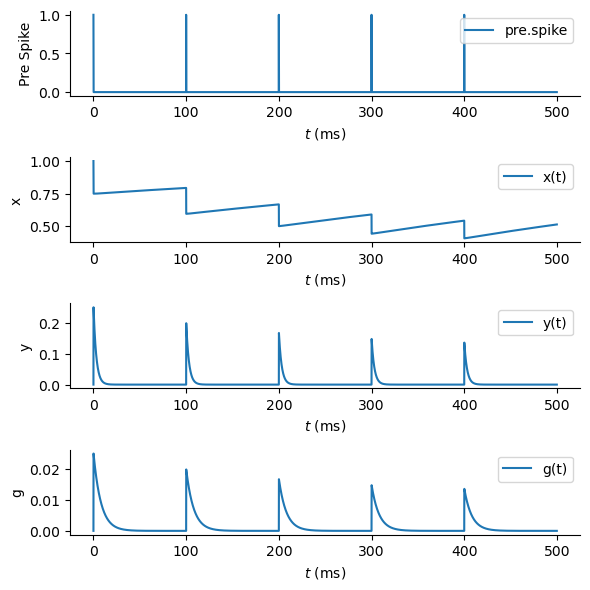

In [56]:

def run_tfstd_model(sp_times, tau_rec=500., tau_in=3., run_duration=200., U=0.25, **kwargs):
    neu1 = bp.neurons.SpikeTimeGroup(1, times=sp_times, indices=[0] * len(sp_times)) #pre neuron
    neu2 = bp.neurons.LIF(1) # post neuron
    syn1 = tf_STD(neu1, neu2, conn=bp.connect.All2All(), tau_rec=tau_rec, tau_in=tau_in, U=U) #synapse 
    net1 = bp.Network(pre=neu1, syn=syn1, post=neu2) # network
    # 运行模拟
    runner1 = bp.DSRunner(net1, monitors=['pre.spike', 'post.V', 'syn.g', 'syn.x', 'syn.y', 'post.input'])
    runner1.run(run_duration)

    # 可视化
    fig1, ax = plt.subplots(4, 1, figsize=(6, 6))
    ax[0].plot(runner1.mon.ts, runner1.mon['pre.spike'][:, 0], label='pre.spike')
    ax[0].spines['right'].set_color('none')
    ax[0].spines['top'].set_color('none')
    ax[0].legend()
    ax[0].set_xlabel(r'$t$ (ms)')
    ax[0].set_ylabel('Pre Spike')

    x = runner1.mon['syn.x'][:, 0]
    ax[1].plot(runner1.mon.ts, x, label='x(t)')
    ax[1].legend()
    ax[1].set_xlabel(r'$t$ (ms)')
    ax[1].set_ylabel('x')
    ax[1].spines['right'].set_color('none')
    ax[1].spines['top'].set_color('none')

    y = runner1.mon['syn.y'][:, 0]
    ax[2].plot(runner1.mon.ts, y, label='y(t)')
    ax[2].legend()
    ax[2].set_xlabel(r'$t$ (ms)')
    ax[2].set_ylabel('y')
    ax[2].spines['right'].set_color('none')
    ax[2].spines['top'].set_color('none')

    g = runner1.mon['syn.g'][:, 0]
    ax[3].plot(runner1.mon.ts, g, label='g(t)')
    ax[3].legend()
    ax[3].set_xlabel(r'$t$ (ms)')
    ax[3].set_ylabel('g')
    ax[3].spines['right'].set_color('none')
    ax[3].spines['top'].set_color('none')
    plt.tight_layout()
    plt.show()

run_tfstd_model(sp_times=spike_time,run_duration=T)

### Underlying mechanism of STD model
Since the time constants of the recover process $\tau_{rec}$ is much slower than the spike time interval, the amount of available neuro-transmitter keeps decreasing, thus giving rise to the short-term depression phenomenon.

## Simplified STD model
By considering the time constants $\tau_{in}$ to be much smaller than $\tau_{rec}$, $y(t)$ can be approximately given by,
$$y(t)= U x^-\delta(t-t_{sp})$$
So the dynamics of the three-factor STD model can be simplified as, 
$$\frac{dx(t)}{dt}=\frac{1-x(t)}{\tau_{rec}}-U x^-\delta(t-t_{sp})$$
$$\frac{dg(t)}{dt}=-\frac{g(t)}{\tau_{s}}+g_{max}Ux^-\delta(t-t_{sp})$$
### Customize simplified STD model in Brainpy

In [57]:

class STD(bp.synapses.TwoEndConn):
    def __init__(self, pre, post, conn, g_max=0.1, U=0.25, tau_rec=500., tau=8., E=1., delay_step=2,
                 method='exp_auto', syn_type='CUBA', **kwargs):
        super(STD, self).__init__(pre=pre, post=post, conn=conn)
        # 初始化参数
        self.tau_rec = tau_rec
        self.tau = tau
        self.U = U
        self.g_max = g_max
        self.E = E
        self.delay_step = delay_step
        self.type = syn_type
        # 获取每个连接的突触前神经元pre_ids和突触后神经元post_ids
        self.pre_ids, self.post_ids = self.conn.require('pre_ids', 'post_ids')

        # 初始化变量
        num = len(self.pre_ids)
        self.x = bm.Variable(bm.ones(num))
        self.g = bm.Variable(bm.zeros(num))
        self.delay = bm.LengthDelay(self.g, delay_step)  # 定义一个处理g的延迟器

        # 定义积分函数
        self.integral = bp.odeint(method=method, f=self.derivative)

    @property 
    def derivative(self):
        dx = lambda x, t: (1 - x) / self.tau_rec
        dg = lambda g, t: -g / self.tau
        return bp.JointEq([dx, dg])

    def update(self):
        # 更新各个变量
        syn_sps = bm.pre2syn(self.pre.spike, self.pre_ids)  # 哪些突触前神经元产生了脉冲
        x, g = self.integral(self.x, self.g, bp.share['t'], bm.dt)
        x = bm.where(syn_sps, x - self.U * self.x, x)  # 更新后的x
        g = bm.where(syn_sps, g + self.g_max * self.U * self.x, g)  # 更新后的g
        self.x.value = x
        self.g.value = g
        # 更新延迟器，将g的计算延迟delay_step的时间步长
        self.delay.update(self.g)
        delayed_g = self.delay(self.delay_step)
        # 计算突触后电流
        post_g = bm.syn2post(delayed_g, self.post_ids, self.post.num)
        self.post.input += post_g * (self.E - self.post.V_rest)


### Run the simplified STD model and compare the outputs with the three-factor STD model

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

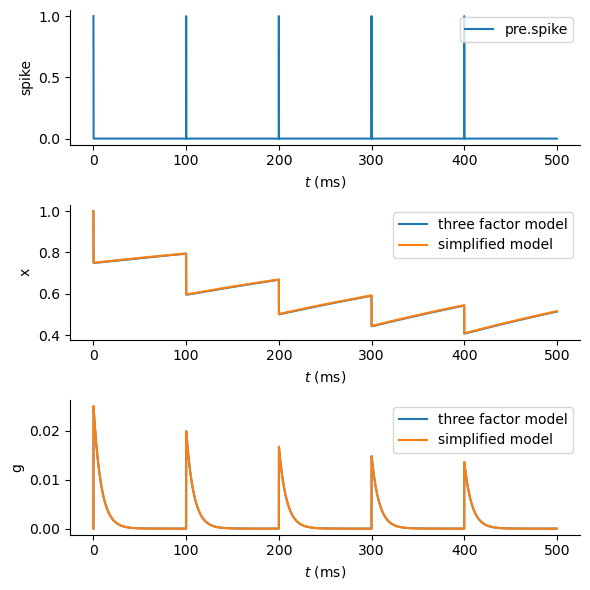

In [58]:
def compare_std_model(sp_times, tau_rec=500., tau_in=3., run_duration=200., U=0.25, **kwargs):
    # 定义两组突触前神经元和突触后神经元
    neu11 = bp.neurons.SpikeTimeGroup(1, times=sp_times, indices=[0] * len(sp_times))
    neu12 = bp.neurons.LIF(1)
    neu21 = bp.neurons.SpikeTimeGroup(1, times=sp_times, indices=[0] * len(sp_times))
    neu22 = bp.neurons.LIF(1)
    # 分别定义两个synapses，分别是three-factor STD和Simplified STD
    syn1 = tf_STD(neu11, neu12, conn=bp.connect.All2All(), tau_rec=tau_rec, tau_in=tau_in, U=U)
    syn2 = STD(neu21, neu22, conn=bp.connect.All2All(), tau_rec=tau_rec, U=U)
    # 构建两个网络
    net1 = bp.Network(pre=neu11, syn=syn1, post=neu12)
    net2 = bp.Network(pre=neu21, syn=syn2, post=neu22)

    # 分别运行模拟
    runner1 = bp.DSRunner(net1, monitors=['pre.spike', 'post.V', 'syn.g', 'syn.x', 'syn.y', 'post.input'])
    runner1.run(run_duration)

    runner2 = bp.DSRunner(net2, monitors=['pre.spike', 'post.V', 'syn.g', 'syn.x', 'post.input'])
    runner2.run(run_duration)

    # 可视化
    fig, ax = plt.subplots(3, 1, figsize=(6, 6))
    ax[0].plot(runner1.mon.ts, runner1.mon['pre.spike'][:, 0], label='pre.spike')
    ax[0].legend()
    ax[0].set_xlabel(r'$t$ (ms)')
    ax[0].set_ylabel('spike')
    ax[0].spines['right'].set_color('none')
    ax[0].spines['top'].set_color('none')
    x1 = runner1.mon['syn.x'][:, 0]
    x2 = runner2.mon['syn.x'][:, 0]
    ax[1].plot(runner1.mon.ts, x1, label='three factor model')
    ax[1].plot(runner2.mon.ts, x2, label='simplified model')
    ax[1].legend()
    ax[1].set_xlabel(r'$t$ (ms)')
    ax[1].set_ylabel('x')
    ax[1].spines['right'].set_color('none')
    ax[1].spines['top'].set_color('none')
    g1 = runner1.mon['syn.g'][:, 0]
    g2 = runner2.mon['syn.g'][:, 0]
    ax[2].plot(runner1.mon.ts, g1, label='three factor model')
    ax[2].plot(runner2.mon.ts, g2, label='simplified model')
    ax[2].legend()
    ax[2].set_xlabel(r'$t$ (ms)')
    ax[2].set_ylabel('g')
    ax[2].spines['right'].set_color('none')
    ax[2].spines['top'].set_color('none')

    plt.tight_layout()
    plt.show()
compare_std_model(sp_times=spike_time,run_duration=T)

### Predict post-synaptic conductance with random Poisson spikes
In order to further validate the effectiveness of the model, we need to first infer the parameter values within the model by fitting them to existing data. Then, by simulating the model, we can predict the changes in postsynaptic membrane current and potential when the synapse receives a new random spike train. 

As an example, we simulate the dynamics of postsynaptic conductance when the presynaptic neuron generates a random Poisson spike train:

  0%|          | 0/5000 [00:00<?, ?it/s]

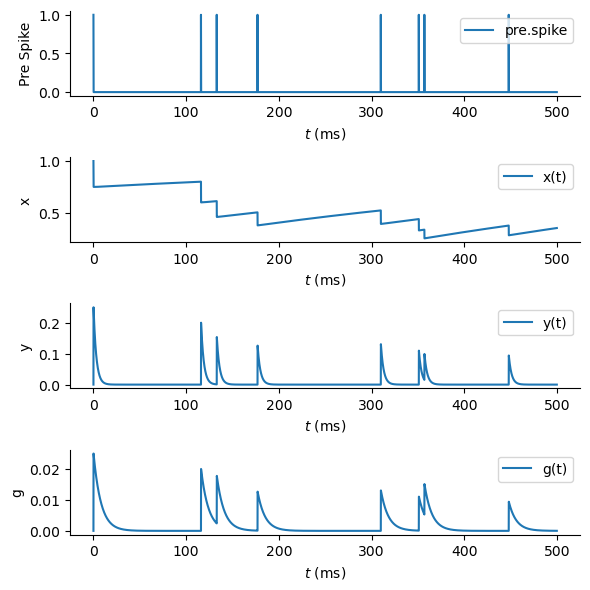

In [59]:
spike_time_Poisson = np.where(spike_train_Poisson == 1)[0]
run_tfstd_model(sp_times=spike_time_Poisson,run_duration=T)

## Model of Short-term Plasticity
By further considering the dynamics of the release probability $u(t)$, the model is capable of accounting for both the short-term depression and the short-term facilitation phenomena. The dynamics of the model can be written as follows:
$$\frac{du(t)}{dt}=-\frac{u(t)}{\tau_{f}}+U (1-u^-) \delta(t-t_{sp})$$
$$\frac{dx(t)}{dt}=\frac{1-x(t)}{\tau_{d}}-u^+x^-\delta(t-t_{sp})$$
$$\frac{dg(t)}{dt}=-\frac{g(t)}{\tau_{s}}+g_{max}u^+x^-\delta(t-t_{sp})$$
### Customize short-term plasticity model in Brainpy

In [60]:
class STP(bp.synapses.TwoEndConn):
    def __init__(self, pre, post, conn, g_max=0.1, U=0.15, tau_f=1500., tau_d=200., tau=8., E=1., delay_step=2,
                 method='exp_auto', syn_type='CUBA', **kwargs):
        super(STP, self).__init__(pre=pre, post=post, conn=conn)
        # 初始化参数
        self.tau_d = tau_d
        self.tau_f = tau_f
        self.tau = tau
        self.U = U
        self.g_max = g_max
        self.E = E
        self.delay_step = delay_step
        self.type = syn_type
        # 获取每个连接的突触前神经元pre_ids和突触后神经元post_ids
        self.pre_ids, self.post_ids = self.conn.require('pre_ids', 'post_ids')

        # 初始化变量
        num = len(self.pre_ids)
        self.x = bm.Variable(bm.ones(num))
        self.u = bm.Variable(bm.zeros(num))
        self.g = bm.Variable(bm.zeros(num))
        self.delay = bm.LengthDelay(self.g, delay_step)  # 定义一个处理g的延迟器

        # 定义积分函数
        self.integral = bp.odeint(method=method, f=self.derivative)

    @property
    def derivative(self):
        du = lambda u, t: -u / self.tau_f
        dx = lambda x, t: (1 - x) / self.tau_d
        dg = lambda g, t: -g / self.tau
        return bp.JointEq([du, dx, dg])

    def update(self):
        # 更新各个变量
        syn_sps = bm.pre2syn(self.pre.spike, self.pre_ids)  # 哪些突触前神经炎产生了脉冲
        u, x, g = self.integral(self.u, self.x, self.g, bp.share['t'], bm.dt)
        u = bm.where(syn_sps, u + self.U * (1 - self.u), u)  # 更新后的u
        x = bm.where(syn_sps, x - u * self.x, x)  # 更新后的x
        g = bm.where(syn_sps, g + self.g_max * u * self.x, g)  # 更新后的g
        self.u.value = u
        self.x.value = x
        self.g.value = g
        # 更新延迟器
        self.delay.update(self.g)
        delayed_g = self.delay(self.delay_step)
        # 计算突触后电流
        post_g = bm.syn2post(delayed_g, self.post_ids, self.post.num)
        self.post.input += post_g * (self.E - self.post.V_rest)

def run_syn_stp(syn_model, title, sp_times, tau_d, tau_f, run_duration=200., **kwargs):
    neu1 = bp.neurons.SpikeTimeGroup(1, times=sp_times, indices=[0] * len(sp_times))
    neu2 = bp.neurons.LIF(1)
    syn1 = syn_model(neu1, neu2, conn=bp.connect.All2All(), tau_d=tau_d, tau_f=tau_f)
    net = bp.Network(pre=neu1, syn=syn1, post=neu2)

    # 运行模拟
    runner = bp.DSRunner(net, monitors=['pre.spike', 'post.V', 'syn.g', 'syn.x', 'syn.u', 'post.input'])
    runner.run(run_duration)
    # 可视化
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))
    ax[0][0].set_title(title)
    ax[0][0].plot(runner.mon.ts, runner.mon['pre.spike'][:, 0], label='pre.spike')
    ax[0][0].spines['right'].set_color('none')
    ax[0][0].spines['top'].set_color('none')
    ax[0][0].legend()
    ax[0][0].set_xlabel(r'$t$ (ms)')
    ax[0][0].set_ylabel('Pre Spike')

    V = runner.mon['post.V'][:, 0] * 10
    ax[0][1].plot(runner.mon.ts, V, label='Post-Synaptic Potential')
    ax[0][1].legend()
    ax[0][1].set_xlabel(r'$t$ (ms)')
    ax[0][1].set_ylabel('PSP (mV)')
    ax[0][1].spines['right'].set_color('none')
    ax[0][1].spines['top'].set_color('none')

    g = runner.mon['syn.g'][:, 0]
    ax[1][0].plot(runner.mon.ts, g, label='g(t)')
    ax[1][0].legend()
    ax[1][0].set_xlabel(r'$t$ (ms)')
    ax[1][0].set_ylabel('Conductance (mA/mV)')
    ax[1][0].spines['right'].set_color('none')
    ax[1][0].spines['top'].set_color('none')

    u = runner.mon['syn.u'][:, 0]
    x = runner.mon['syn.x'][:, 0]
    ax[1][1].plot(runner.mon.ts, u, label='u(t)')
    ax[1][1].plot(runner.mon.ts, x, label='x(t)')
    ax[1][1].plot(runner.mon.ts, x * u, label='u(t)*x(t)')
    ax[1][1].legend()
    ax[1][1].set_xlabel(r'$t$ (ms)')
    # ax[1].set_ylabel('EPSP (mV)')
    ax[1][1].spines['right'].set_color('none')
    ax[1][1].spines['top'].set_color('none')
    plt.tight_layout()
    plt.show()

### Simulate short-term plasticity by considering slow depression and fast facilitation

  0%|          | 0/5000 [00:00<?, ?it/s]

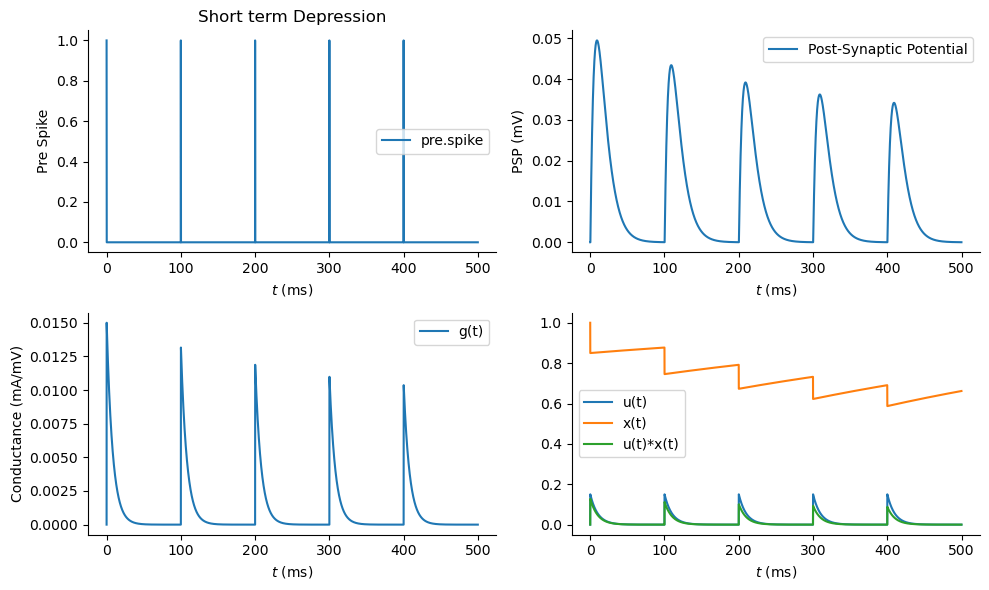

In [61]:
tau_d = 500.
tau_f = 10.
run_syn_stp(STP, title='Short term Depression', sp_times=spike_time, run_duration=T, syn_type='CUBA',
            tau_d=tau_d, tau_f=tau_f)

### Simulate short-term plasticity by considering fast depression and slow facilitation

  0%|          | 0/5000 [00:00<?, ?it/s]

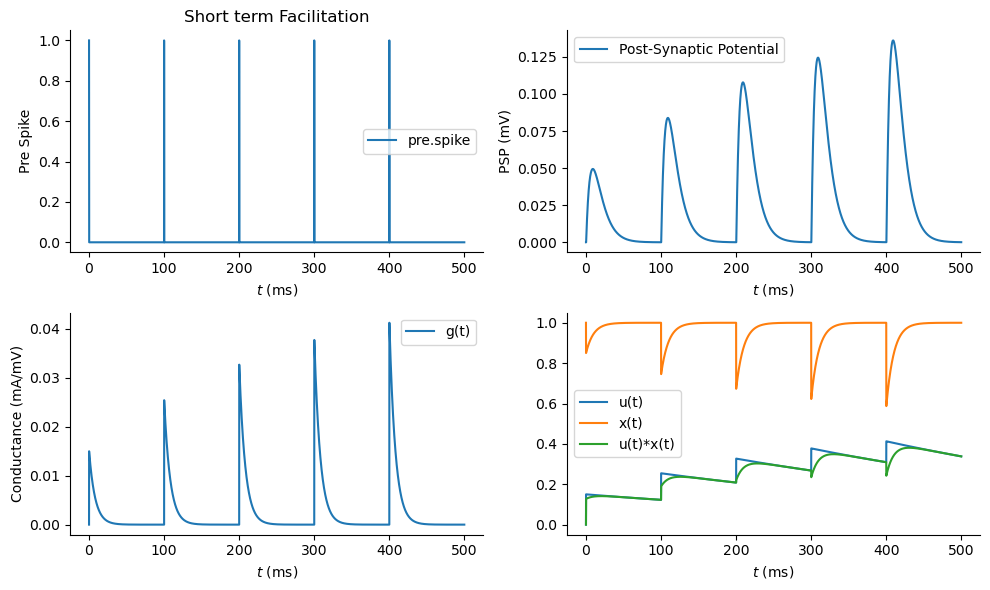

In [62]:
tau_d = 10.
tau_f = 500.
run_syn_stp(STP, title='Short term Facilitation', sp_times=spike_time, run_duration=T, syn_type='CUBA',
            tau_d=tau_d, tau_f=tau_f)

# Effects on Information transmission of STP
## Rate-based STP model
We investigate the information transmission of STP by studying the time average response of short-term plasticity. 
By doing so, the spiking-based STP model is transfered to rate-based STP model, which can be written as,
$$\frac{du(t)}{dt}=-\frac{u(t)}{\tau_f}+U[1-u(t)]R(t)$$
$$\frac{dx(t)}{dt}=\frac{1-x(t)}{\tau_d}-u^+x(t)R(t)$$
$$g(t) = \tau_s g_{max} u^+ x(t)R(t)$$
$$u^+ = u+U(1-u)$$
### Customize the rate-based STP model

In [63]:
class STP_rate(bp.DynamicalSystemNS): 
    def __init__(self, tau_d=500., tau_f=500., U=0.15, tau=8., g_max=0.1, method='exp_auto'):
        super(STP_rate, self).__init__()
        # 初始化参数
        self.tau_d = tau_d
        self.tau_f = tau_f
        self.tau = tau
        self.g_max = g_max
        self.U = U
        # 初始化变量
        self.x = bm.Variable(bm.ones(1))
        self.u = bm.Variable(bm.zeros(1))
        self.g = bm.Variable(bm.zeros(1))

        # 定义积分函数
        self.integral = bp.odeint(method=method, f=self.derivative)
    @property
    def derivative(self):
        du = lambda u, t, input: -u / self.tau_f + self.U * (1 - u) * input #input指的是pre-synaptic firing rate R(t)
        dx = lambda x, t, u, input: (1 - x) / self.tau_d - (u + self.U * (1 - u)) * x * input
        return bp.JointEq([du, dx])

    def update(self, input_):
        # 更新各个变量
        u, x = self.integral(self.u, self.x, bp.share['t'],  input_, bm.dt)
        self.u.value = u
        self.x.value = x
        self.g.value = self.tau * self.g_max * (u + self.U * (1 - u)) * x * input_

### Compare the simulation results of spiking-based STP model and rate-based STP model
To verify whether the rate-based model replicate the time-average response spiking-based STP model, we compare the simulation results of spiking-based STP and rate-based STP,

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

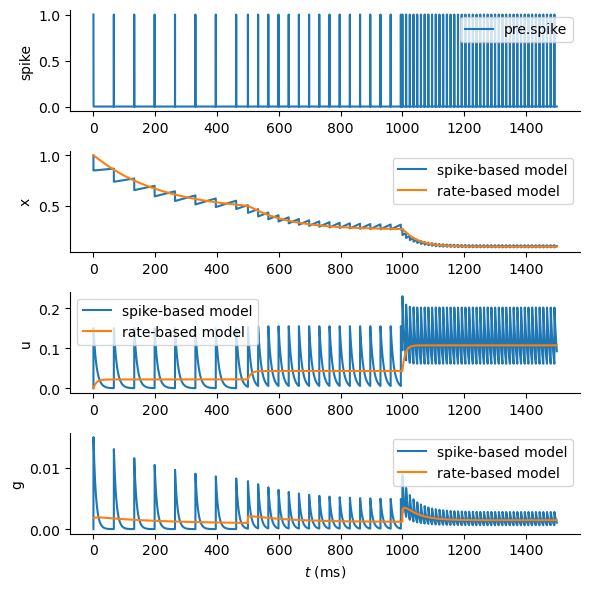

In [64]:

def compare_spike_rate_Stp(tau_d=500., tau_f=10., U=0.15):
    T1 = 500
    T2 = 500
    T3 = 500
    fr_1 = 15
    fr_2 = 30
    fr_3 = 80
    # 假设pre-synaptic spike 的频率在0-1000ms是1hz，在1000-2000ms是10hz，在2000-3000ms是20hz，
    # 模拟spike based stp,
    spike_1 = Pre_spike_generator(type='Regular', fr=fr_1, T=T1)
    spike_2 = Pre_spike_generator(type='Regular', fr=fr_2, T=T2)
    spike_3 = Pre_spike_generator(type='Regular', fr=fr_3, T=T3)
    spike_train = np.concatenate((spike_1, spike_2, spike_3))
    spike_time = np.where(spike_train == 1)[0]
    neu1 = bp.neurons.SpikeTimeGroup(1, times=spike_time, indices=[0] * len(spike_time))
    neu2 = bp.neurons.LIF(1)
    syn1 = STP(neu1, neu2, conn=bp.connect.All2All(), tau_d=tau_d, tau_f=tau_f, U=U)
    net = bp.Network(pre=neu1, syn=syn1, post=neu2)
    runner_spike = bp.DSRunner(net, monitors=['pre.spike', 'post.V', 'syn.g', 'syn.x', 'syn.u', 'post.input'])
    runner_spike.run(T1 + T2 + T3)
    
    # 模拟rate based stp,
    dyn_sys = STP_rate(tau_d=tau_d, tau_f=tau_f, U=U)
    # 分段电流
    inputs = bp.inputs.section_input(values=[fr_1 * 1e-3, fr_2 * 1e-3, fr_3 * 1e-3],
                                     durations=[T1, T2, T3])
    # 运行模拟
    runner_rate = bp.DSRunner(dyn_sys, monitors=['u', 'x', 'g'])
    runner_rate.run(inputs=inputs)

    # 可视化
    fig1, ax = plt.subplots(4, 1, figsize=(6, 6))
    ax[0].plot(runner_spike.mon.ts, runner_spike.mon['pre.spike'][:, 0], label='pre.spike')
    ax[0].legend()
    ax[0].set_ylabel('spike')
    ax[0].spines['right'].set_color('none')
    ax[0].spines['top'].set_color('none')
    x_spike = runner_spike.mon['syn.x'][:, 0]
    x_rate = runner_rate.mon['x'][:, 0]
    ax[1].plot(runner_spike.mon.ts, x_spike, label='spike-based model')
    ax[1].plot(runner_rate.mon.ts, x_rate, label='rate-based model')
    ax[1].legend()
    ax[1].set_ylabel('x')
    ax[1].spines['right'].set_color('none')
    ax[1].spines['top'].set_color('none')
    u_spike = runner_spike.mon['syn.u'][:, 0]
    u_rate = runner_rate.mon['u'][:, 0]
    ax[2].plot(runner_spike.mon.ts, u_spike, label='spike-based model')
    ax[2].plot(runner_rate.mon.ts, u_rate, label='rate-based model')
    ax[2].legend()
    ax[2].set_ylabel('u')
    ax[2].spines['right'].set_color('none')
    ax[2].spines['top'].set_color('none')

    g_spike = runner_spike.mon['syn.g'][:, 0]
    g_rate = runner_rate.mon['g'][:, 0]
    ax[3].plot(runner_spike.mon.ts, g_spike, label='spike-based model')
    ax[3].plot(runner_rate.mon.ts, g_rate, label='rate-based model')
    ax[3].legend()
    ax[3].set_xlabel(r'$t$ (ms)')
    ax[3].set_ylabel('g')
    ax[3].spines['right'].set_color('none')
    ax[3].spines['top'].set_color('none')
    plt.tight_layout()
    plt.show()
compare_spike_rate_Stp()

## Frequency-dependent facilitation or depression
Considering the pre-synaptic neuron fires with a constant firing rate $R_0$, by substituting the time derivative $dx/dt$ and $du/dt$ with zero in rate-based STP model, we can solve the theoretical solution of the stationary state of $u(t)$, $x(t)$, $u^+$ and $g(t)$ , which is written as,
$$u_{st} = \frac{UR_0\tau_f}{1+UR_0\tau_f}$$
$$u_{st}^+ = U\frac{1+R_0\tau_f}{1+UR_0\tau_f}$$
$$x_{st} = \frac{1}{1+u_{st}^+R_0\tau_d}$$
$$EPSC_{st} \propto g_{st} = g_{max} \frac{u_{st}^+}{1+u_{st}^+R_0\tau_d}$$
### Simulate the relation between $EPSC_{st}$ and $R_0$

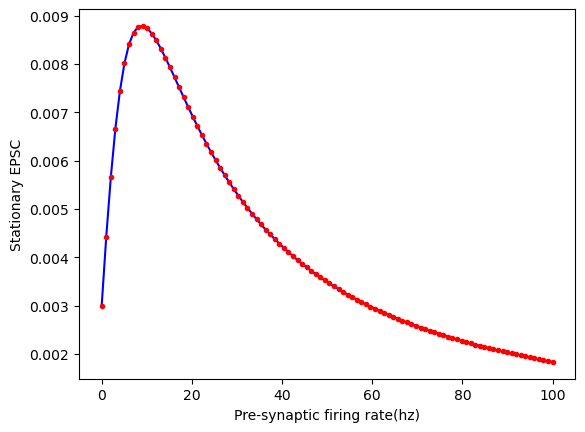

In [67]:
def EPSC_st(tau_f, tau_d, R0, U, g_max):
    u_st = U*(1+R0*tau_f)/(1+U*R0*tau_f)
    x_st = 1/(1+u_st*R0*tau_f)
    g_st = g_max*u_st*x_st
    return g_st
tau_d=130.
tau_f=530.
U=0.03
n = 100
R0 = np.linspace(0,100,n)*1e-3
g_max = 0.1
EPSC = np.zeros([n,])
for i in range(n):
    EPSC[i] = EPSC_st(tau_f = tau_f,tau_d=tau_d,R0 = R0[i], U=U,g_max=g_max)
plt.plot(R0*1e3, EPSC, 'b')
plt.plot(R0*1e3, EPSC, 'r.')
plt.xlabel('Pre-synaptic firing rate(hz)')
plt.ylabel('Stationary EPSC')
plt.show()

From the above results, we can observe that when the presynaptic neuron's firing rate is low, the steady-state EPSC is greater than the initial EPSC (stationary EPSC when the presynaptic firing rate is 0), which means that the synaptic short-term plasticity is primarily dominated as facilitation. However, as the firing rate increases, the steady-state EPSC first increases and then decreases, ultimately becoming smaller than the initial EPSC. This indicates that the short-term facilitation and depression of the synapse are correlated with the firing frequency of the presynaptic neuron.
### Simulate the frequency-dependent STF and STD

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

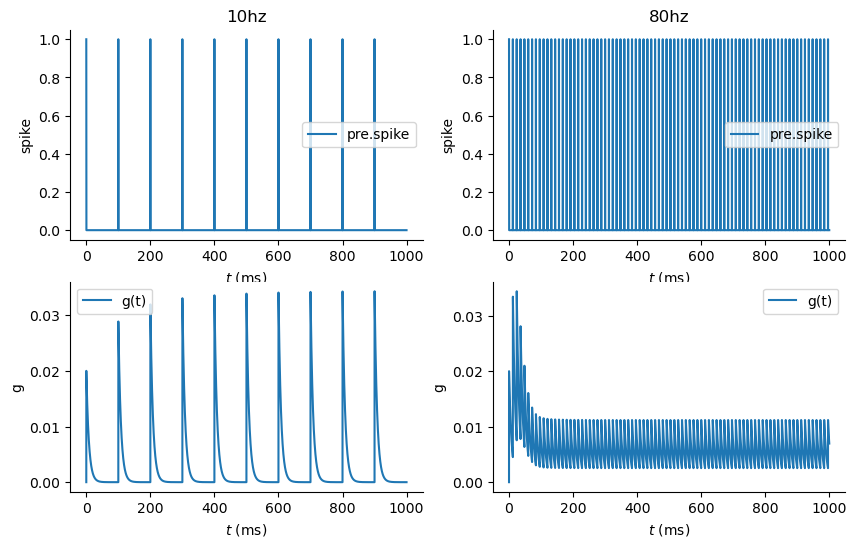

In [68]:

def frequency_dependent_STF(tau_d=130., tau_f=330., U=0.2):
    T = 1000
    fr_1 = 10
    fr_2 = 80
    # 假设pre-synaptic spike 的频率在0-1000ms是1hz，在1000-2000ms是10hz，在2000-3000ms是20hz，
    # 模拟spike based stp,
    spike_1 = Pre_spike_generator(type='Regular', fr=fr_1, T=T)
    spike_2 = Pre_spike_generator(type='Regular', fr=fr_2, T=T)
    spike_time_1 = np.where(spike_1 == 1)[0]
    spike_time_2 = np.where(spike_2 == 1)[0]
    neu_pre1 = bp.neurons.SpikeTimeGroup(1, times=spike_time_1, indices=[0] * len(spike_time_1))
    neu_pre2 = bp.neurons.SpikeTimeGroup(1, times=spike_time_2, indices=[0] * len(spike_time_2))
    neu_post1 = bp.neurons.LIF(1)
    neu_post2 = bp.neurons.LIF(1)
    syn1 = STP(neu_pre1, neu_post1, conn=bp.connect.All2All(), tau_d=tau_d, tau_f=tau_f, U=U)
    syn2 = STP(neu_pre2, neu_post2, conn=bp.connect.All2All(), tau_d=tau_d, tau_f=tau_f, U=U)
    net1 = bp.Network(pre=neu_pre1, syn=syn1, post=neu_post1)
    net2 = bp.Network(pre=neu_pre2, syn=syn2, post=neu_post2)
    runner_1 = bp.DSRunner(net1, monitors=['pre.spike', 'post.V', 'syn.g', 'syn.x', 'syn.u', 'post.input'])
    runner_1.run(T)
    runner_2 = bp.DSRunner(net2, monitors=['pre.spike', 'post.V', 'syn.g', 'syn.x', 'syn.u', 'post.input'])
    runner_2.run(T)

    # 可视化
    fig1, ax = plt.subplots(2, 2, figsize=(10, 6))
    ax[0][0].set_title('10hz')
    ax[0][0].plot(runner_1.mon.ts, runner_1.mon['pre.spike'][:, 0], label='pre.spike')
    ax[0][0].legend()
    ax[0][0].set_xlabel(r'$t$ (ms)')
    ax[0][0].set_ylabel('spike')
    ax[0][0].spines['right'].set_color('none')
    ax[0][0].spines['top'].set_color('none')
    g_1 = runner_1.mon['syn.g'][:, 0]
    ax[1][0].plot(runner_1.mon.ts, g_1, label='g(t)')
    ax[1][0].legend()
    ax[1][0].set_xlabel(r'$t$ (ms)')
    ax[1][0].set_ylabel('g')
    ax[1][0].spines['right'].set_color('none')
    ax[1][0].spines['top'].set_color('none')

    ax[0][1].set_title('80hz')
    ax[0][1].plot(runner_2.mon.ts, runner_2.mon['pre.spike'][:, 0], label='pre.spike')
    ax[0][1].legend()
    ax[0][1].set_xlabel(r'$t$ (ms)')
    ax[0][1].set_ylabel('spike')
    ax[0][1].spines['right'].set_color('none')
    ax[0][1].spines['top'].set_color('none')
    g_2 = runner_2.mon['syn.g'][:, 0]
    ax[1][1].plot(runner_2.mon.ts, g_2, label='g(t)')
    ax[1][1].legend()
    ax[1][1].set_xlabel(r'$t$ (ms)')
    ax[1][1].set_ylabel('g')
    ax[1][1].spines['right'].set_color('none')
    ax[1][1].spines['top'].set_color('none')
    plt.show()
frequency_dependent_STF()

The EPSC represents the postsynaptic current generated by each spike from the presynaptic neuron and can indicate the synaptic transmission efficiency - the larger the EPSC, the higher the transmission efficiency. Given the correlation between EPSC and the presynaptic neuron's firing rate, this implies that Short-Term Plasticity (STP) may serve as a synaptic mechanism to implement frequency-dependent gain control. 
### Simulate the gain control 
The synaptic transmission efficiency is related to the presynaptic neuron's firing rate, and there exists an optimal frequency favored by the synapse. We simulate the EPSC of a STP synapse receiving three different pre-synaptic firing rate, and check the frequency-dependent gain control phenomenon.

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

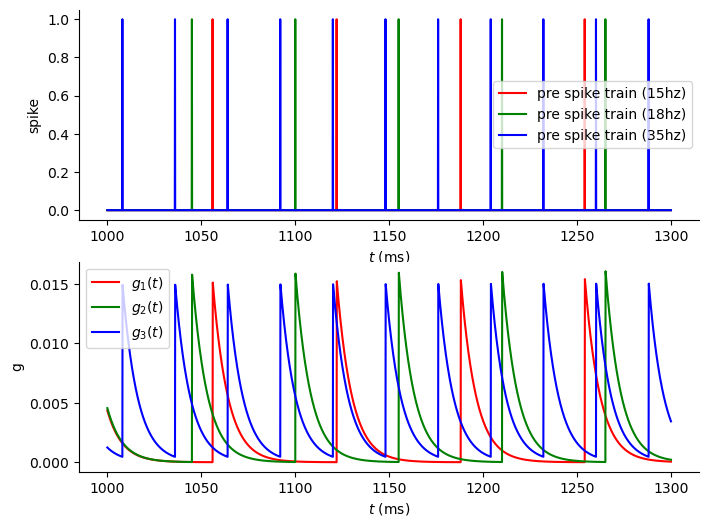

In [71]:

def Gain_control(fr_1=15, fr_2=18, fr_3=35, tau_d=130., tau_f=530., U=0.03):
    T = 1300
    fr_1 = fr_1
    fr_2 = fr_2
    fr_3 = fr_3
    spike_1 = Pre_spike_generator(type='Regular', fr=fr_1, T=T)
    spike_2 = Pre_spike_generator(type='Regular', fr=fr_2, T=T)
    spike_3 = Pre_spike_generator(type='Regular', fr=fr_3, T=T)
    spike_time_1 = np.where(spike_1 == 1)[0]
    spike_time_2 = np.where(spike_2 == 1)[0]
    spike_time_3 = np.where(spike_3 == 1)[0]

    neu_pre1 = bp.neurons.SpikeTimeGroup(1, times=spike_time_1, indices=[0] * len(spike_time_1))
    neu_pre2 = bp.neurons.SpikeTimeGroup(1, times=spike_time_2, indices=[0] * len(spike_time_2))
    neu_pre3 = bp.neurons.SpikeTimeGroup(1, times=spike_time_3, indices=[0] * len(spike_time_3))
    neu_post1 = bp.neurons.LIF(1)
    neu_post2 = bp.neurons.LIF(1)
    neu_post3 = bp.neurons.LIF(1)
    syn1 = STP(neu_pre1, neu_post1, conn=bp.connect.All2All(), tau_d=tau_d, tau_f=tau_f, U=U)
    syn2 = STP(neu_pre2, neu_post2, conn=bp.connect.All2All(), tau_d=tau_d, tau_f=tau_f, U=U)
    syn3 = STP(neu_pre3, neu_post3, conn=bp.connect.All2All(), tau_d=tau_d, tau_f=tau_f, U=U)
    net1 = bp.Network(pre=neu_pre1, syn=syn1, post=neu_post1)
    net2 = bp.Network(pre=neu_pre2, syn=syn2, post=neu_post2)
    net3 = bp.Network(pre=neu_pre3, syn=syn3, post=neu_post3)

    runner_1 = bp.DSRunner(net1, monitors=['pre.spike', 'post.V', 'syn.g', 'syn.x', 'syn.u', 'post.input'])
    runner_1.run(T)
    runner_2 = bp.DSRunner(net2, monitors=['pre.spike', 'post.V', 'syn.g', 'syn.x', 'syn.u', 'post.input'])
    runner_2.run(T)
    runner_3 = bp.DSRunner(net3, monitors=['pre.spike', 'post.V', 'syn.g', 'syn.x', 'syn.u', 'post.input'])
    runner_3.run(T)

    # 可视化
    fig1, ax = plt.subplots(2, 1, figsize=(8, 6))
    start_time = 10000
    time = runner_1.mon.ts[start_time:]
    ax[0].plot(time, runner_1.mon['pre.spike'][start_time:, 0], 'r', label='pre spike train ({}hz)'.format(fr_1))
    ax[0].plot(time, runner_2.mon['pre.spike'][start_time:, 0], 'g', label='pre spike train ({}hz)'.format(fr_2))
    ax[0].plot(time, runner_3.mon['pre.spike'][start_time:, 0], 'b', label='pre spike train ({}hz)'.format(fr_3))
    ax[0].legend()
    ax[0].set_xlabel(r'$t$ (ms)')
    ax[0].set_ylabel('spike')
    ax[0].spines['right'].set_color('none')
    ax[0].spines['top'].set_color('none')

    g_1 = runner_1.mon['syn.g'][start_time:, 0]
    g_2 = runner_2.mon['syn.g'][start_time:, 0]
    g_3 = runner_3.mon['syn.g'][start_time:, 0]
    ax[1].plot(time, g_1, 'r', label=r'$g_1(t)$')
    ax[1].plot(time, g_2, 'g', label=r'$g_2(t)$')
    ax[1].plot(time, g_3, 'b', label=r'$g_3(t)$')
    ax[1].legend()
    ax[1].set_xlabel(r'$t$ (ms)')
    ax[1].set_ylabel('g')
    ax[1].spines['right'].set_color('none')
    ax[1].spines['top'].set_color('none')
    plt.show()
Gain_control()